# **Imports**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, Lars, PassiveAggressiveRegressor, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import l2
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from keras.optimizers import Adam
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, RationalQuadratic, Matern, ExpSineSquared

# **Without Parameter Fine-Tuning**

1 Physical GPUs, 1 Logical GPUs
6/6 [==============================] - 0s 5ms/step


<Figure size 1000x600 with 0 Axes>

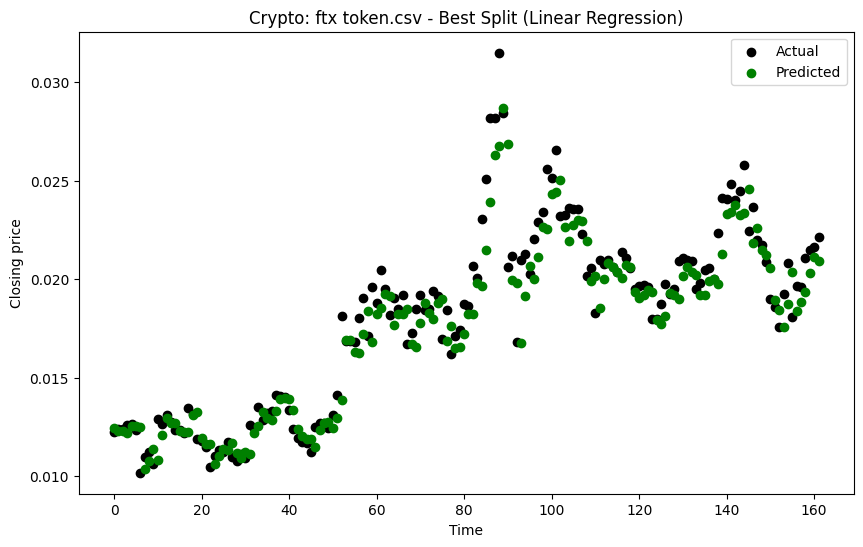

6/6 [==============================] - 0s 4ms/step


<Figure size 1000x600 with 0 Axes>

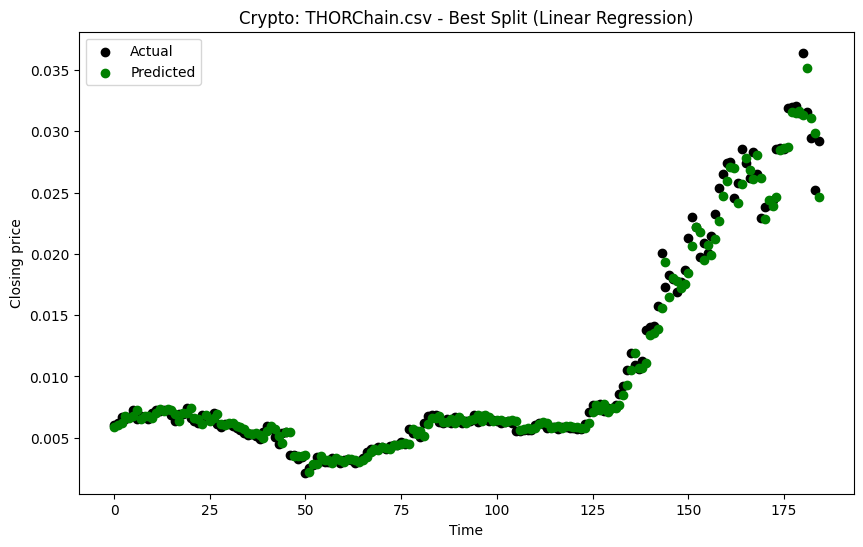

11/11 [==============================] - 0s 4ms/step


<Figure size 1000x600 with 0 Axes>

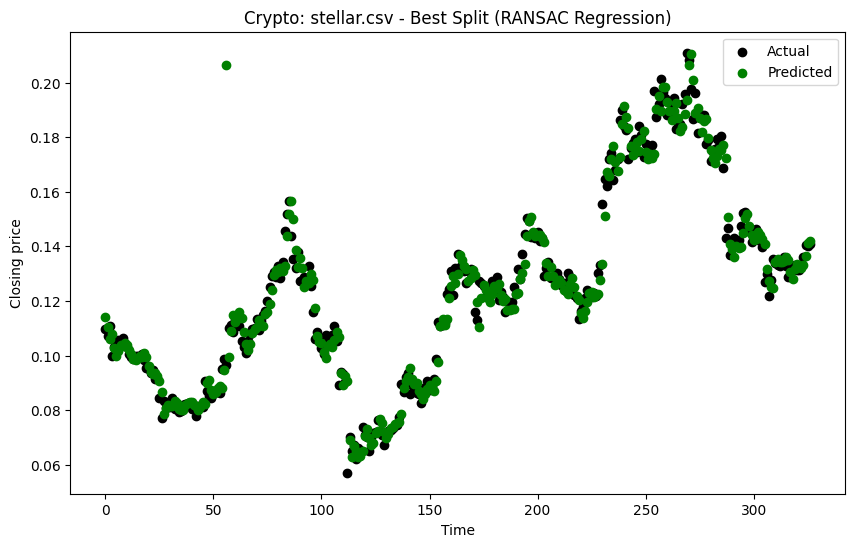

4/4 [==============================] - 0s 5ms/step


<Figure size 1000x600 with 0 Axes>

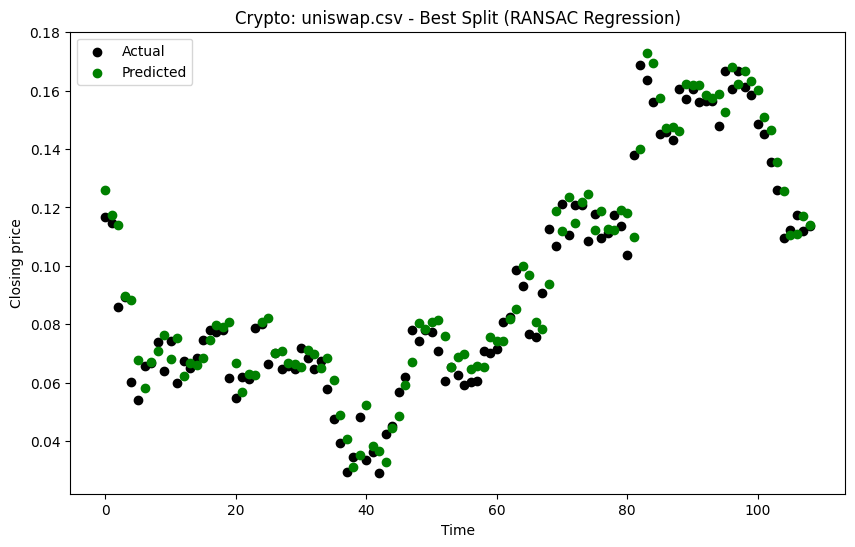

1/1 [==============================] - 0s 437ms/step


1/1 [==============================] - 0s 438ms/step


1/1 [==============================] - 0s 434ms/step


1/1 [==============================] - 0s 451ms/step


1/1 [==============================] - 0s 449ms/step


<Figure size 1000x600 with 0 Axes>

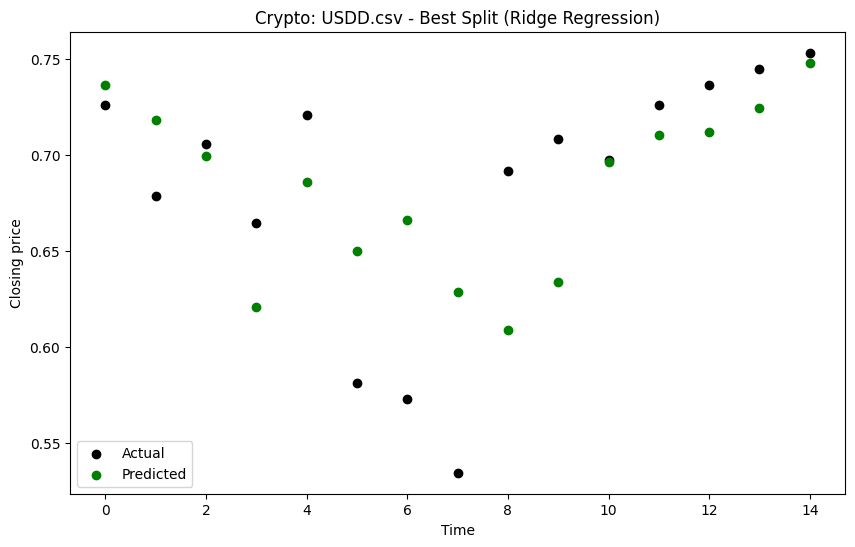

6/6 [==============================] - 0s 5ms/step


<Figure size 1000x600 with 0 Axes>

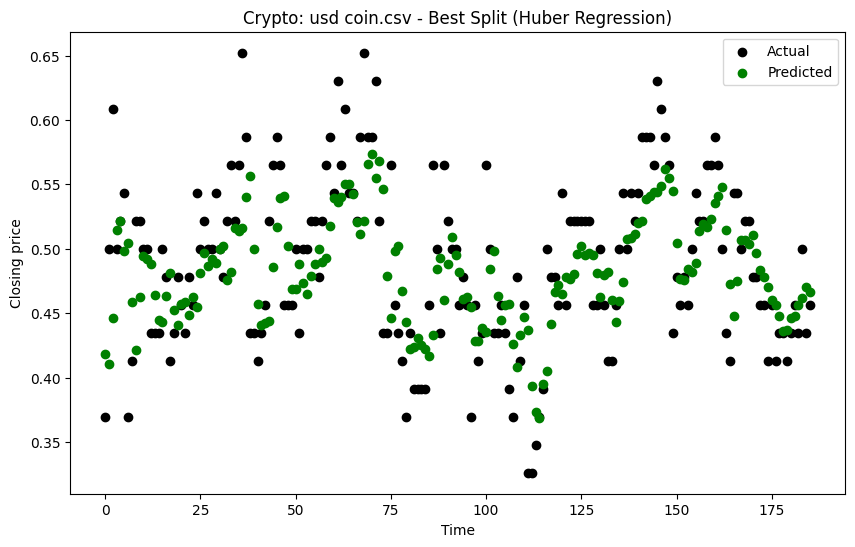

9/9 [==============================] - 0s 4ms/step


<Figure size 1000x600 with 0 Axes>

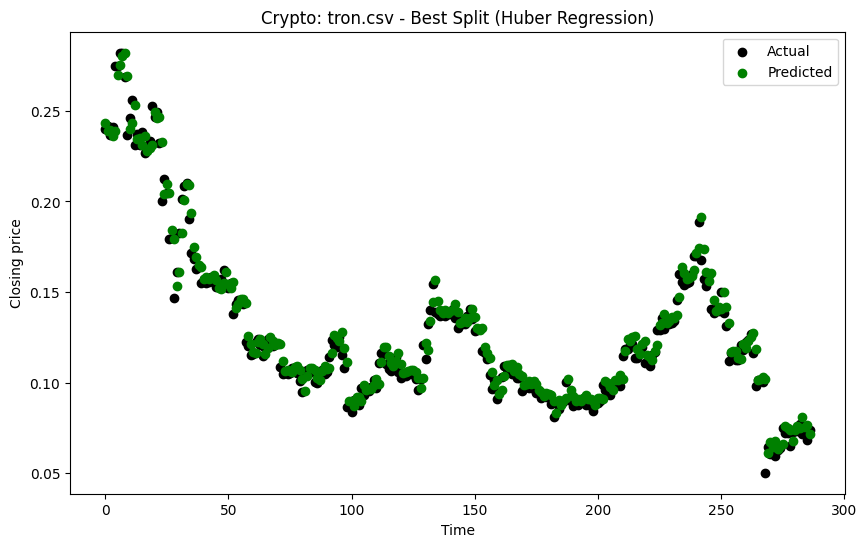

11/11 [==============================] - 1s 5ms/step


<Figure size 1000x600 with 0 Axes>

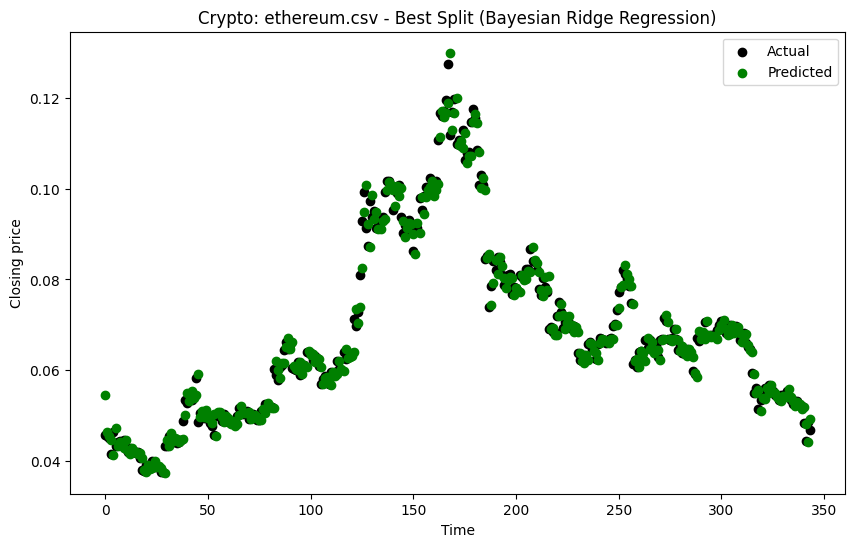

4/4 [==============================] - 0s 6ms/step


<Figure size 1000x600 with 0 Axes>

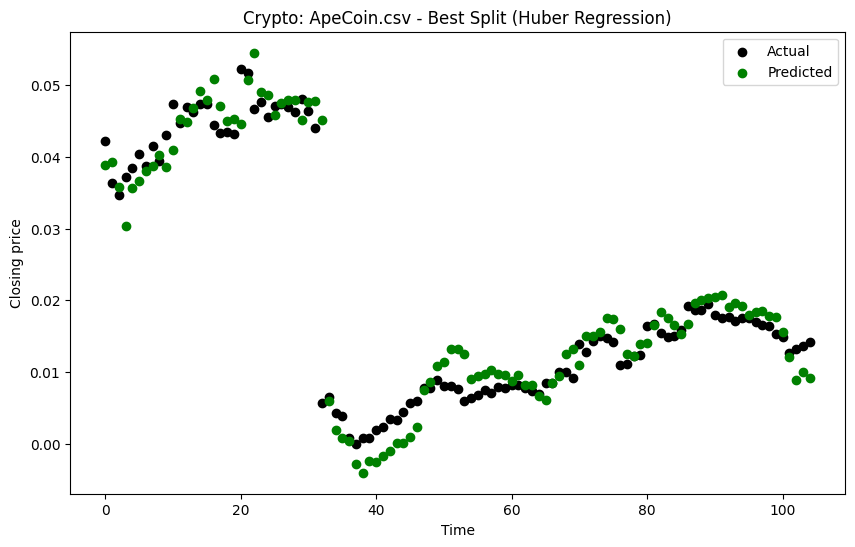

9/9 [==============================] - 0s 4ms/step


<Figure size 1000x600 with 0 Axes>

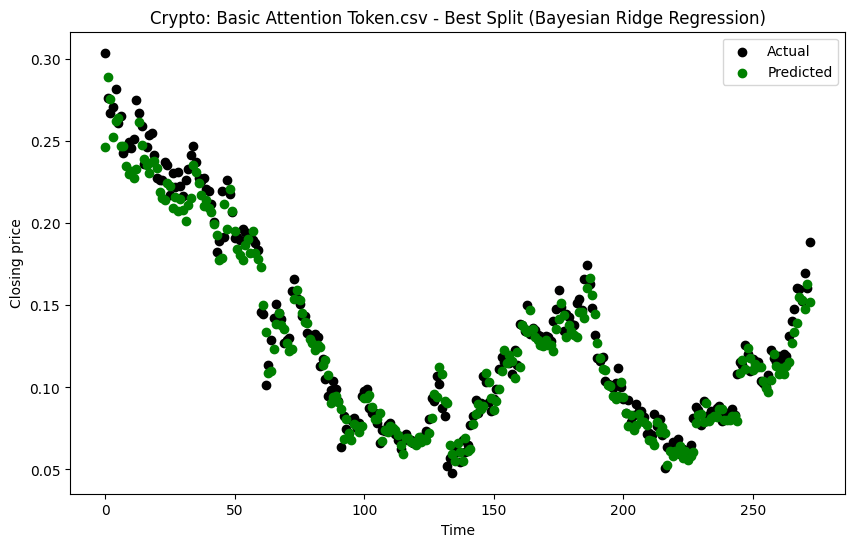

5/5 [==============================] - 0s 5ms/step


<Figure size 1000x600 with 0 Axes>

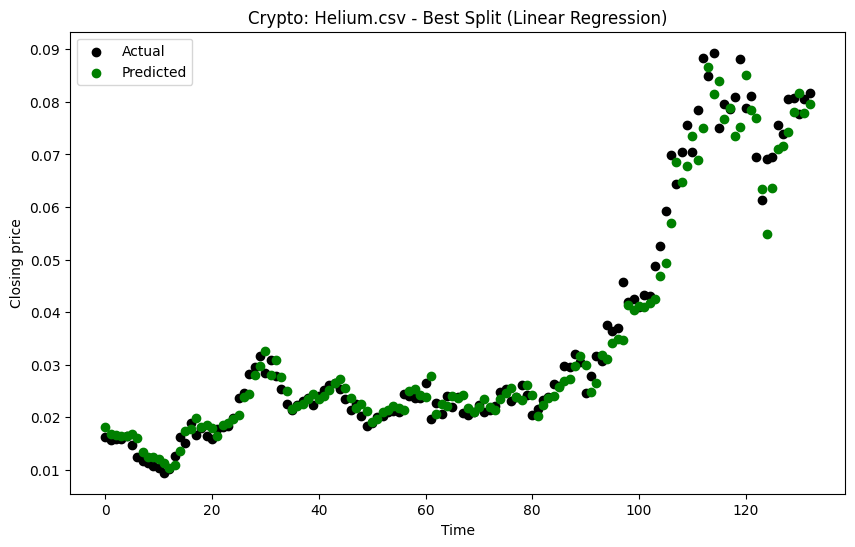

9/9 [==============================] - 0s 5ms/step


<Figure size 1000x600 with 0 Axes>

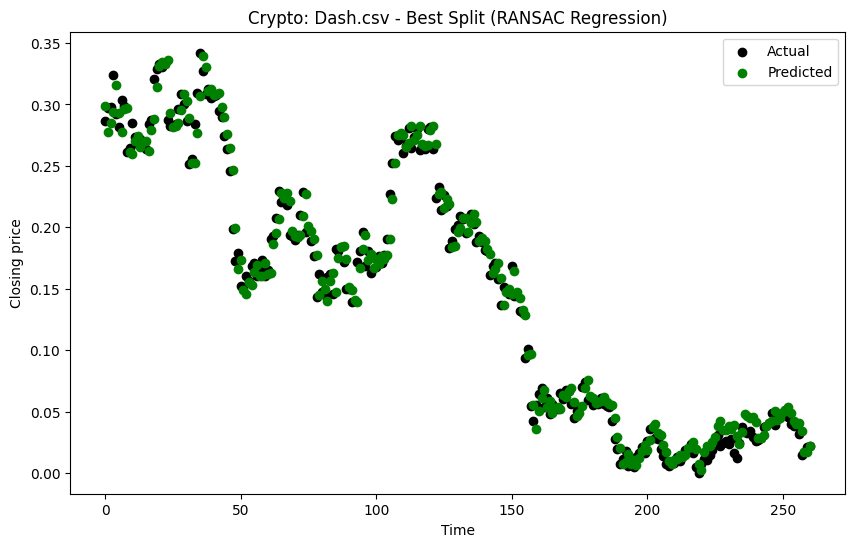

12/12 [==============================] - 0s 5ms/step


<Figure size 1000x600 with 0 Axes>

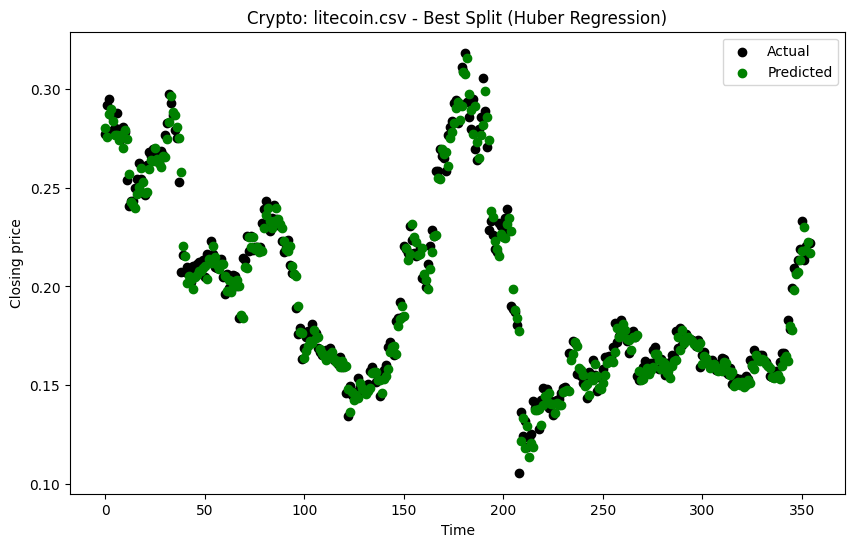

9/9 [==============================] - 1s 8ms/step


<Figure size 1000x600 with 0 Axes>

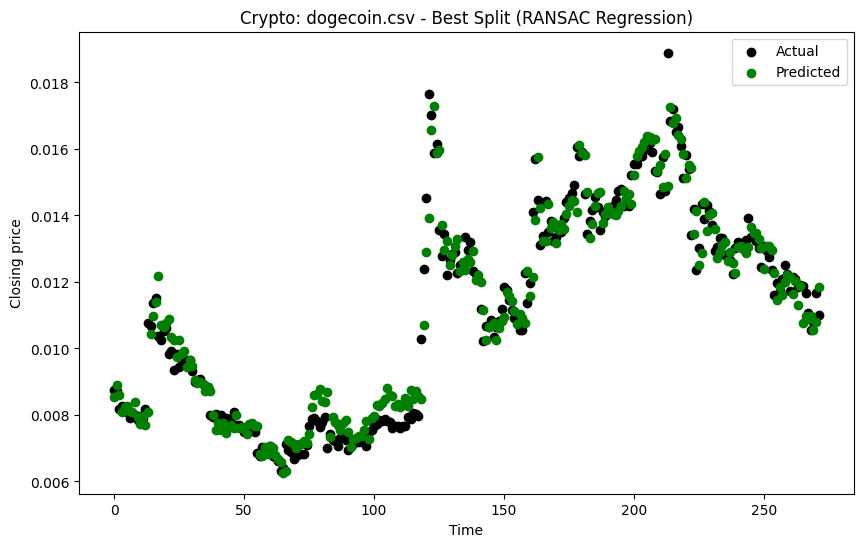

9/9 [==============================] - 1s 6ms/step


<Figure size 1000x600 with 0 Axes>

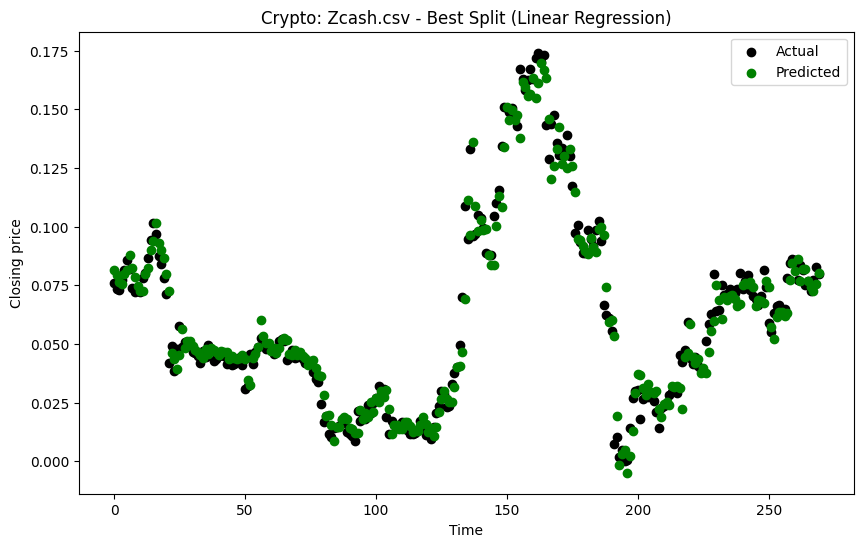

5/5 [==============================] - 0s 6ms/step


<Figure size 1000x600 with 0 Axes>

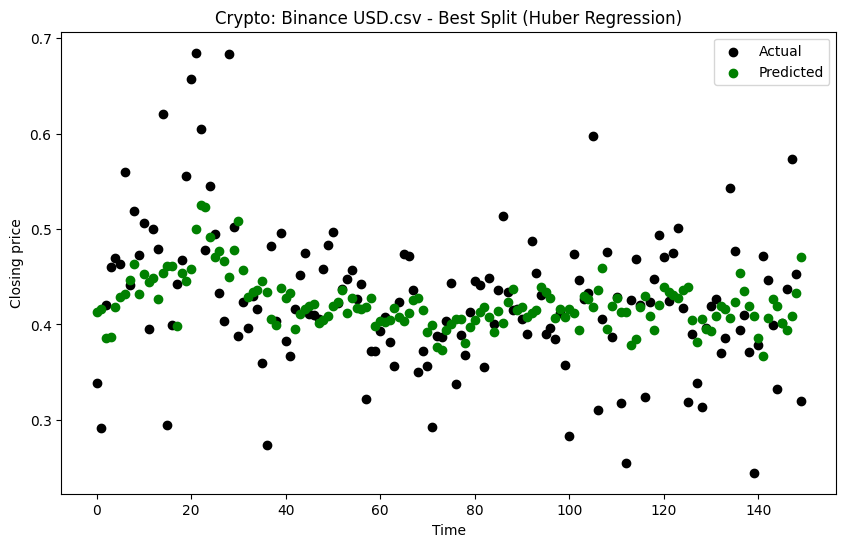

4/4 [==============================] - 0s 6ms/step


<Figure size 1000x600 with 0 Axes>

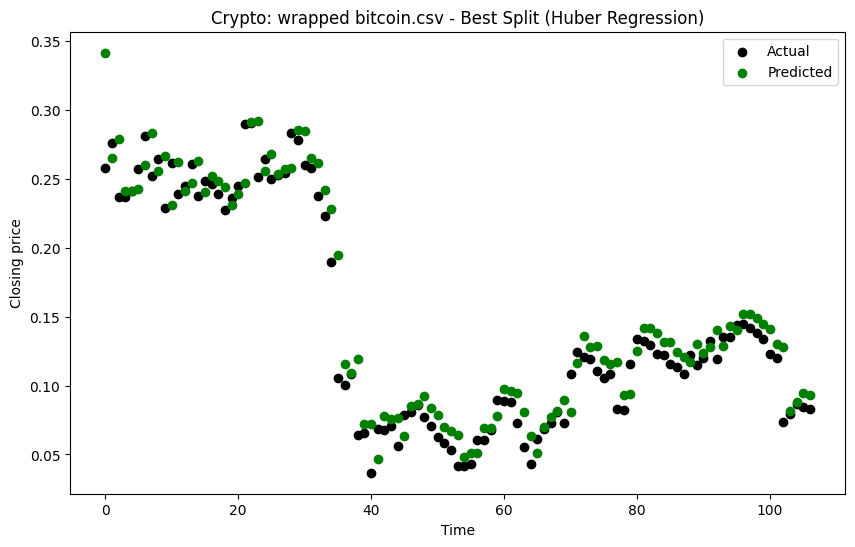

4/4 [==============================] - 0s 6ms/step


<Figure size 1000x600 with 0 Axes>

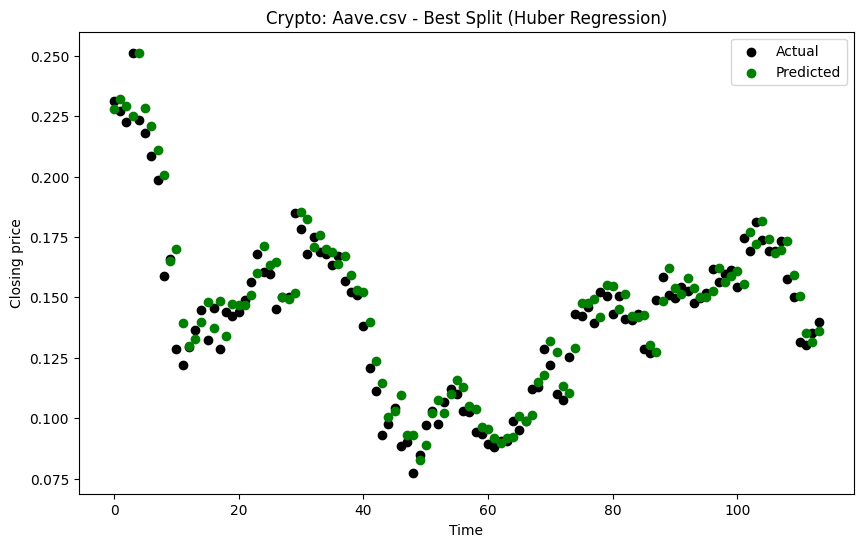

6/6 [==============================] - 0s 5ms/step


<Figure size 1000x600 with 0 Axes>

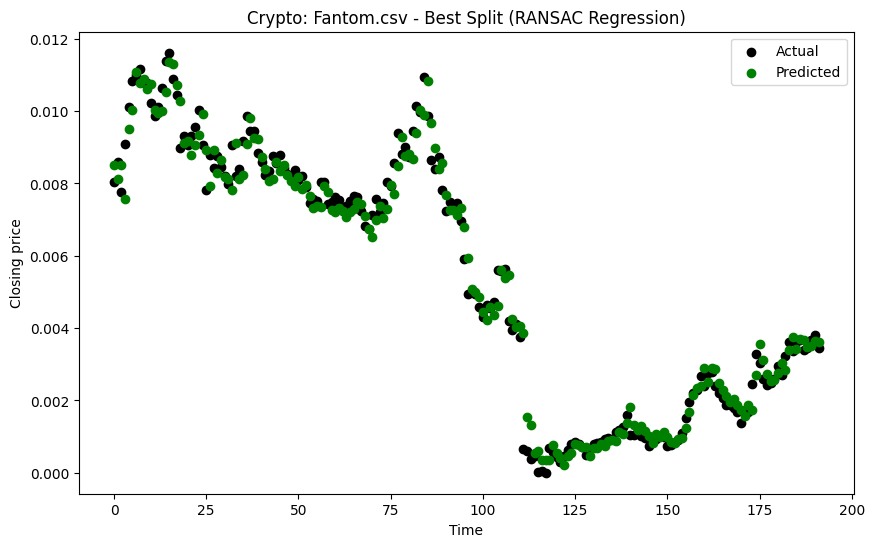

20/20 [==============================] - 1s 5ms/step


<Figure size 1000x600 with 0 Axes>

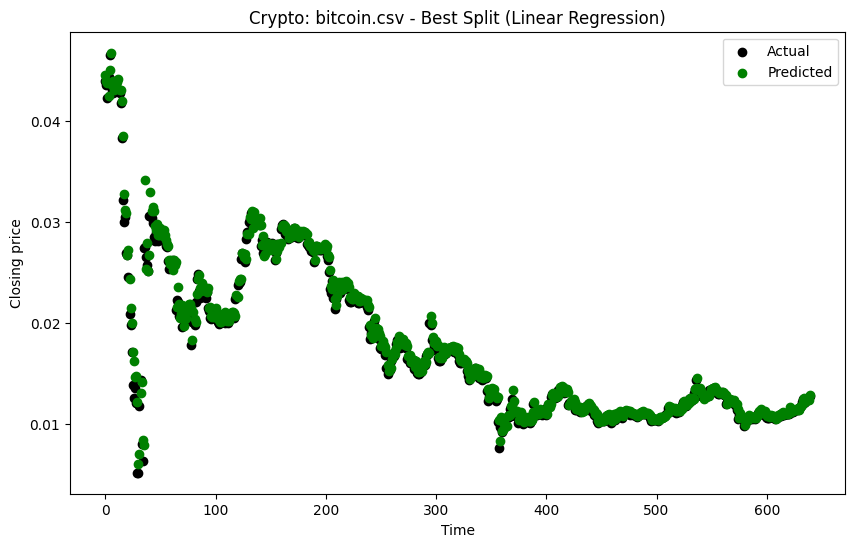

In [ ]:
# DataFrame to store performance metrics for all methods
results_df = pd.DataFrame(columns=['File', 'Method', 'RMSE', 'MAE'])

# Check if GPU is available and set device placement
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available, falling back to CPU.")

# Répertoire contenant les fichiers CSV des crypto-monnaies
directory = "crypto_data"

# Iterate over all files in the directory
for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):
        try:
            data = pd.read_csv(os.path.join(directory, file_name))
            # Ensure the file contains the required columns
            if all(col in data.columns for col in ['Open', 'High', 'Low', 'Close', 'Volume']):
                # Remove outliers using IQR method
                Q1 = data['Close'].quantile(0.25)
                Q3 = data['Close'].quantile(0.75)
                IQR = Q3 - Q1
                data = data[(data['Close'] > (Q1 - 1.5 * IQR)) & (data['Close'] < (Q3 + 1.5 * IQR))].reset_index()

                # Normalize the data
                scaler = MinMaxScaler()
                data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

                # Feature selection: Open, High, Low, Close, Volume
                X = data[['Open', 'High', 'Low', 'Volume']].shift(1)  # Shift features backward by one day
                # Target selection: Next day's closing price
                y = data['Close'].shift(-1)  # Shift target variable forward by one day

                # Drop the last row (NaN in y) and the first row (NaN in X due to shifting)
                X = X.iloc[1:]
                y = y.dropna()

                # Adding moving averages
                sma_10 = data['Close'].rolling(window=2).mean().fillna(0)
                sma_20 = data['Close'].rolling(window=3).mean().fillna(0)

                # Adding RSI (Relative Strength Index)
                delta = data['Close'].diff()
                gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
                rs = gain / loss
                rsi = 100 - (100 / (1 + rs))
                rsi = rsi.fillna(0)

                # Adding MACD (Moving Average Convergence Divergence)
                ema_12 = data['Close'].ewm(span=12, min_periods=0, adjust=False).mean()
                ema_26 = data['Close'].ewm(span=26, min_periods=0, adjust=False).mean()
                macd = ema_12 - ema_26
                macd_signal = macd.ewm(span=9, min_periods=0, adjust=False).mean()

                # Calculate historical volatility (HV) or standard deviation of returns
                historical_volatility = data['Close'].pct_change().rolling(window=20).std().fillna(0)

               # Concatenate the additional features with X after shifting them backward by one day
                additional_features = pd.concat([sma_10, sma_20, rsi, macd, macd_signal, historical_volatility], axis=1).shift(1).dropna()
                X = np.column_stack((X, additional_features))


                # Perform time series cross-validation
                tscv = TimeSeriesSplit(n_splits=5)

                # Define the methods to try
                methods = {
                    "Linear Regression": LinearRegression(),
                    "Ridge Regression": Ridge(),
                    "Random Forest Regression": RandomForestRegressor(),
                    "Gradient Boosting Regression": GradientBoostingRegressor(),
                    "Support Vector Regression": SVR(),
                    "K-Nearest Neighbors Regression": KNeighborsRegressor(),
                    "Bayesian Ridge Regression": BayesianRidge(),
                    "Huber Regression": HuberRegressor(max_iter=int(1e6)),
                    "Lars Regression": Lars(),
                    "Passive Aggressive Regression": PassiveAggressiveRegressor(),
                    "RANSAC Regression": RANSACRegressor(),
                    "Decision Tree Regression": DecisionTreeRegressor(),
                    "Gaussian Process Regression": GaussianProcessRegressor(),
                    "Multi-layer Perceptron Regression": MLPRegressor(solver='adam', max_iter=int(1e6)),
                    "AdaBoost Regression": AdaBoostRegressor(),
                    "XGBoost Regression": XGBRegressor(),
                    "CatBoost Regression": CatBoostRegressor(verbose=0),
                    "Recurrent Neural Network": Sequential([ LSTM(512, return_sequences=True, input_shape=(X.shape[1], 1)),
                                                            Dropout(0.1),
                                                             LSTM(1024, activation='relu', kernel_regularizer=l2(0.0001)),
                                                             Dropout(0.2),
                                                             Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
                                                             Dropout(0.1),
                                                             Dense(1, activation='relu')])
                }

                # Set up a single plot for each CSV file
                plt.figure(figsize=(10, 6))

                best_rmse = float('inf')
                best_method = None
                best_predictions = None

                # Iterate over the TimeSeriesSplit splits
                for train_index, test_index in tscv.split(X):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    # Iterate over the methods
                    for method_name, method in methods.items():
                        if method_name == "Recurrent Neural Network":
                            # Reshape data for RNN input
                            X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
                            X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
                            # Building and training the model
                            method.compile(loss='mean_squared_error', optimizer='adam')
                            method.fit(X_train_rnn, y_train, verbose=0)
                        else:
                            # Building and training the model
                            method.fit(X_train, y_train)
                        # Prediction on the test set
                        y_pred = method.predict(X_test).flatten()

                        # Compute performance metrics
                        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                        mae = mean_absolute_error(y_test, y_pred)
                        # Store results in the DataFrame
                        results_df = pd.concat([results_df, pd.DataFrame({'File': [file_name], 'Method': [method_name],
                                                        'RMSE': [rmse], 'MAE': [mae]})], ignore_index=True)

                        # Keep the best split
                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_method = method_name
                            close = y_test
                            best_predictions = y_pred

                # Plotting results for the best split
                plt.figure(figsize=(10, 6))
                plt.scatter(range(len(close)), close, color='black', label='Actual')
                plt.scatter(range(len(close)), best_predictions, color='green', label='Predicted')
                plt.title(f'Crypto: {file_name} - Best Split ({best_method})')
                plt.xlabel('Time')
                plt.ylabel('Closing price')
                plt.legend()
                plt.show()

            else:
                print(f"The file {file_name} does not contain required columns.")
        except Exception as e:
            print(f"An error occurred while processing the file {file_name}: {str(e)}")

# Sorting the results by RMSE
results_df = results_df.sort_values(by='RMSE')

In [ ]:
# Displaying the sorted results
results_df.groupby('Method').mean().sort_values(by='RMSE')

<ipython-input-3-a663fb825814>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby('Method').mean().sort_values(by='RMSE')


,RMSE,MAE
Method,,
Bayesian Ridge Regression,0.045147,0.032425
Huber Regression,0.048543,0.035416
Ridge Regression,0.057226,0.043450
Linear Regression,0.059193,0.043153
Random Forest Regression,0.083845,0.064106
Gradient Boosting Regression,0.089767,0.069147
RANSAC Regression,0.089779,0.065990
AdaBoost Regression,0.093076,0.073918
XGBoost Regression,0.096508,0.074693


from matplotlib import pyplot as plt
_df_0['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='RMSE', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE'}, axis=1)
              .sort_values('RMSE', ascending=True))
  xs = counted['RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('RMSE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

<Figure size 2000x1000 with 0 Axes>

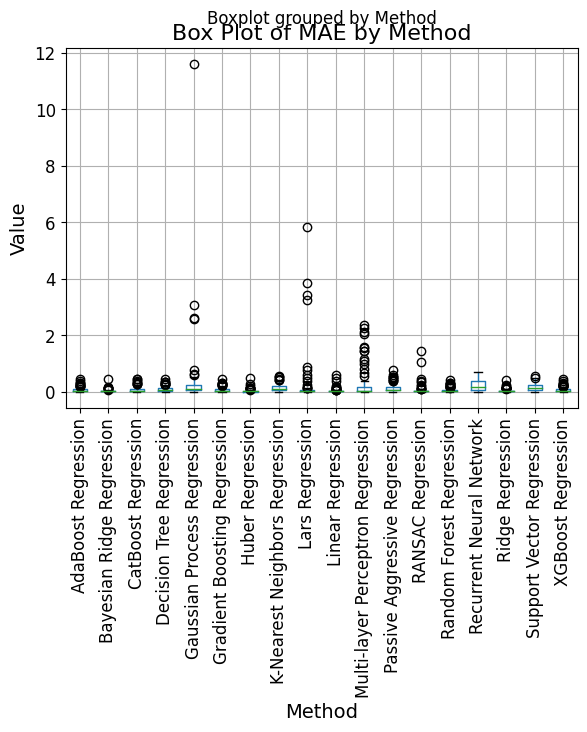

<Figure size 2000x1000 with 0 Axes>

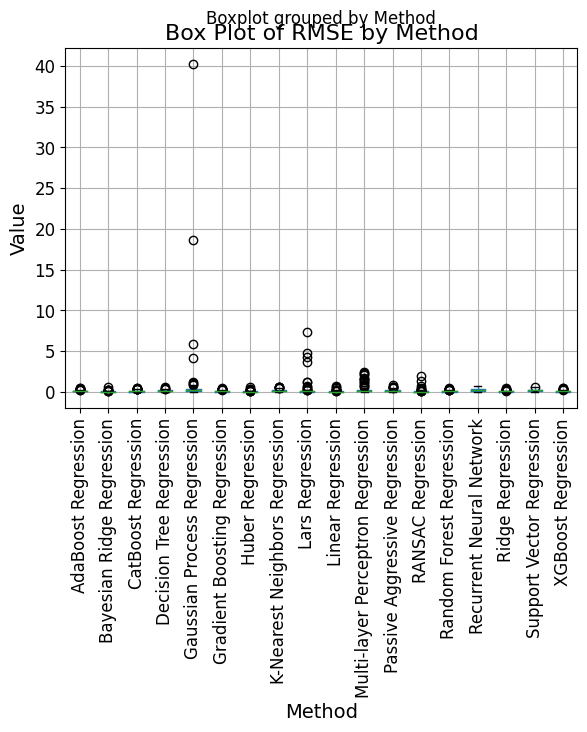

In [ ]:
plt.figure(figsize=(20, 10))  # Increase width to 20 inches and height to 10 inches
results_df.boxplot(column=['MAE'], by='Method', rot=90)
plt.title('Box Plot of MAE by Method', fontsize=16)  # Adjust title fontsize
plt.xlabel('Method', fontsize=14)  # Adjust xlabel fontsize
plt.ylabel('Value', fontsize=14)  # Adjust ylabel fontsize
plt.xticks(fontsize=12)  # Adjust xticks fontsize
plt.yticks(fontsize=12)  # Adjust yticks fontsize
plt.show()

plt.figure(figsize=(20, 10))  # Increase width to 20 inches and height to 10 inches
results_df.boxplot(column=['RMSE'], by='Method', rot=90)
plt.title('Box Plot of RMSE by Method', fontsize=16)  # Adjust title fontsize
plt.xlabel('Method', fontsize=14)  # Adjust xlabel fontsize
plt.ylabel('Value', fontsize=14)  # Adjust ylabel fontsize
plt.xticks(fontsize=12)  # Adjust xticks fontsize
plt.yticks(fontsize=12)  # Adjust yticks fontsize
plt.show()

<Figure size 2000x1000 with 0 Axes>

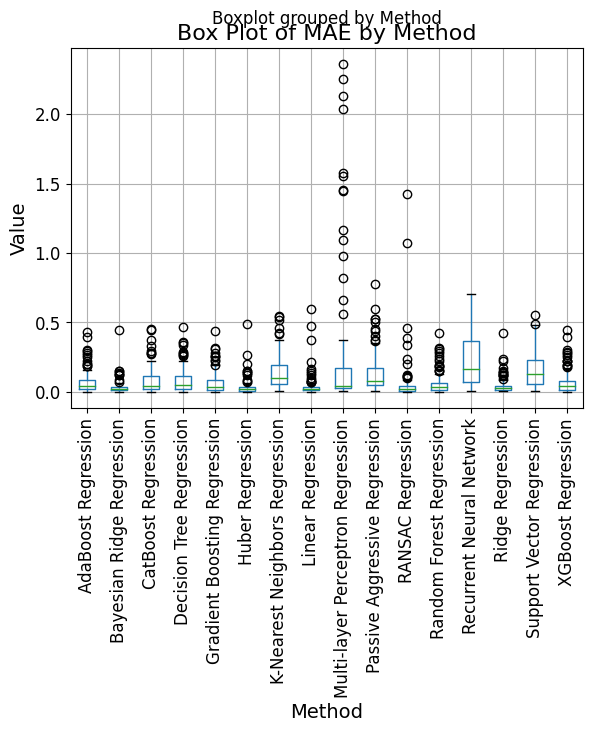

<Figure size 2000x1000 with 0 Axes>

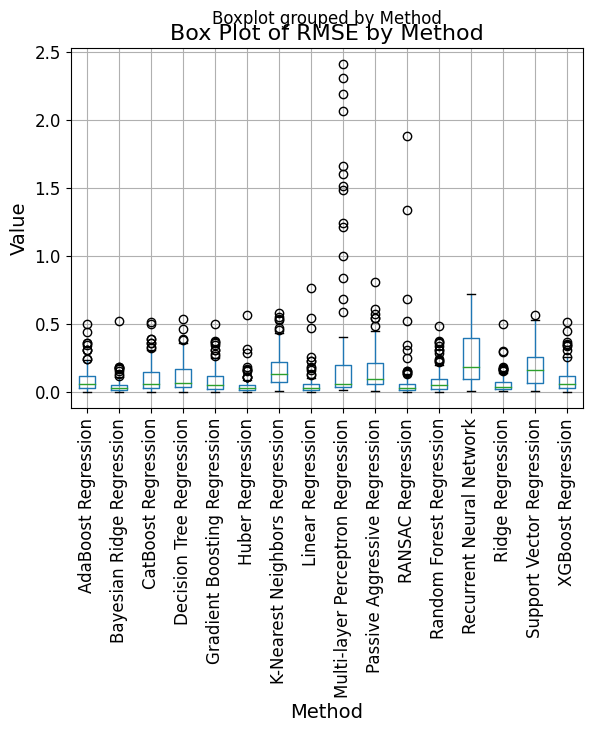

In [ ]:
plt.figure(figsize=(20, 10))  # Increase width to 20 inches and height to 10 inches
results_df[~results_df['Method'].isin(['Gaussian Process Regression', 'Lars Regression'])].boxplot(column=['MAE'], by='Method', rot=90)
plt.title('Box Plot of MAE by Method', fontsize=16)  # Adjust title fontsize
plt.xlabel('Method', fontsize=14)  # Adjust xlabel fontsize
plt.ylabel('Value', fontsize=14)  # Adjust ylabel fontsize
plt.xticks(fontsize=12)  # Adjust xticks fontsize
plt.yticks(fontsize=12)  # Adjust yticks fontsize
plt.show()

plt.figure(figsize=(20, 10))  # Increase width to 20 inches and height to 10 inches
results_df[~results_df['Method'].isin(['Gaussian Process Regression', 'Lars Regression'])].boxplot(column=['RMSE'], by='Method', rot=90)
plt.title('Box Plot of RMSE by Method', fontsize=16)  # Adjust title fontsize
plt.xlabel('Method', fontsize=14)  # Adjust xlabel fontsize
plt.ylabel('Value', fontsize=14)  # Adjust ylabel fontsize
plt.xticks(fontsize=12)  # Adjust xticks fontsize
plt.yticks(fontsize=12)  # Adjust yticks fontsize
plt.show()

# **With Parameter Fine-Tuning**

In [ ]:
# Define the function to calculate moving averages
def calculate_moving_averages(data, window_sizes):
    moving_averages = {}
    for window_size in window_sizes:
        sma_name = f'SMA_{window_size}'
        rolling_mean = data['Close'].rolling(window=window_size, min_periods=1).mean()  # min_periods=1 to handle NaNs in the beginning
        moving_averages[sma_name] = rolling_mean
    return moving_averages

# Define the function to calculate additional indicators
def calculate_additional_indicators(data):
    # Calculate Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    # Calculate Moving Average Convergence Divergence (MACD)
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=9, adjust=False).mean()

    # Calculate Historical Volatility
    historical_volatility = data['Close'].rolling(window=21, min_periods=1).std() * np.sqrt(252)  # 21 trading days in a month, 252 trading days in a year

    return rsi, macd, macd_signal, historical_volatility

# Directory containing the CSV files of cryptocurrencies
directory = "crypto_data"

# Define rolling window sizes to try
window_sizes = list(range(2,40))

# Dictionary to store MAPE for each window size and each file
mape_dict = {}

# Iterate over all files in the directory
for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):
        try:
            data = pd.read_csv(os.path.join(directory, file_name))
            # Ensure the file contains the necessary columns
            if 'Close' in data.columns:
                # Extract the "Close" column separately and shift it to align with the features
                close_values = data['Close'].shift(-1)
                # Calculate moving averages
                moving_averages = calculate_moving_averages(data, window_sizes)
                # Calculate additional indicators
                rsi, macd, macd_signal, historical_volatility = calculate_additional_indicators(data)
                # Iterate over each window size
                for window_size in window_sizes:
                    # Combine features for the current window size
                    features = pd.concat([moving_averages[f'SMA_{window_size}'], rsi, macd, macd_signal, historical_volatility], axis=1)
                    # Drop rows with NaN values
                    features.dropna(inplace=True)
                    close_values_subset = close_values[:len(features)]  # Trim close values to match features
                    # Train-test split (for simplicity, using the last 20% as test data)
                    split_index = int(0.8 * len(features))
                    X_train, X_test = features.iloc[:split_index], features.iloc[split_index:]
                    y_train, y_test = close_values_subset.iloc[:split_index], close_values_subset.iloc[split_index:]
                    # Train a linear regression model
                    model = LinearRegression()
                    model.fit(X_train, y_train)
                    # Predict on test data
                    y_pred = model.predict(X_test)
                    # Calculate MAPE
                    mape = mean_absolute_percentage_error(y_test, y_pred)
                    # Store MAPE for the current window size and file
                    mape_dict[(file_name, window_size)] = mape
        except Exception as e:
            print(f"An error occurred while processing the file {file_name}: {str(e)}")

# Find the window size with the smallest MAPE for each file
best_hyperparameters = {}
for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):
        mape_values = {window_size: mape_dict[(file_name, window_size)] for window_size in window_sizes}
        best_window_size = min(mape_values, key=mape_values.get)
        best_mape = mape_values[best_window_size]
        best_hyperparameters[file_name] = {'best_window_size': best_window_size, 'best_mape': best_mape}

# Print the best hyperparameters for each file
for file_name, params in best_hyperparameters.items():
    print(f"For file {file_name}: Best window size: {params['best_window_size']} with MAPE: {params['best_mape']}")

For file ftx token.csv: Best window size: 2 with MAPE: 0.01519022293950203
For file THORChain.csv: Best window size: 3 with MAPE: 0.031286700341092
For file stellar.csv: Best window size: 2 with MAPE: 0.017652693210312285
For file uniswap.csv: Best window size: 2 with MAPE: 0.03287086868511692
For file USDD.csv: Best window size: 27 with MAPE: 0.0005916589848166296
For file usd coin.csv: Best window size: 12 with MAPE: 0.0003142925188426616
For file tron.csv: Best window size: 2 with MAPE: 0.01476765505082312
For file ethereum.csv: Best window size: 2 with MAPE: 0.019594944829412583
For file ApeCoin.csv: Best window size: 12 with MAPE: 2.0375041981271544
For file Basic Attention Token.csv: Best window size: 2 with MAPE: 0.02239618453603331
For file Helium.csv: Best window size: 2 with MAPE: 0.0240324923684457
For file Dash.csv: Best window size: 2 with MAPE: 0.02234270062771581
For file litecoin.csv: Best window size: 2 with MAPE: 0.018438518659522982
For file dogecoin.csv: Best window

1 Physical GPUs, 1 Logical GPUs


<Figure size 1000x600 with 0 Axes>

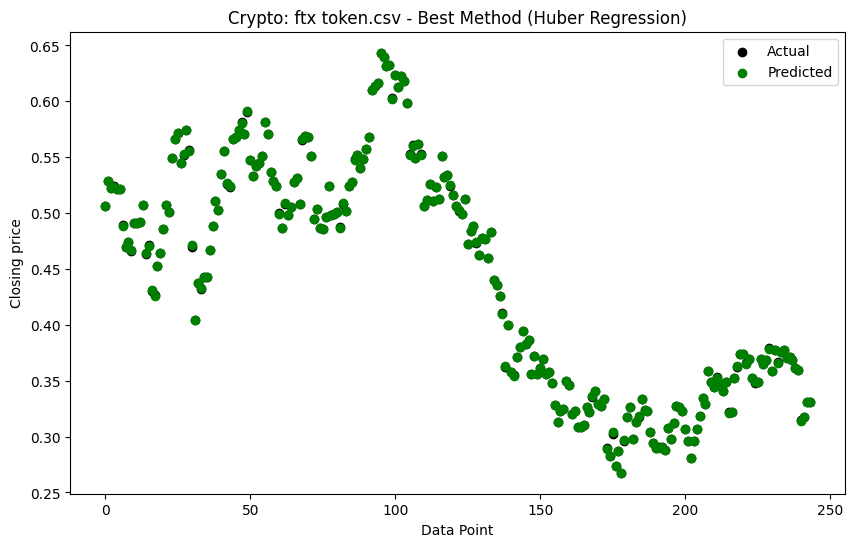

<Figure size 1000x600 with 0 Axes>

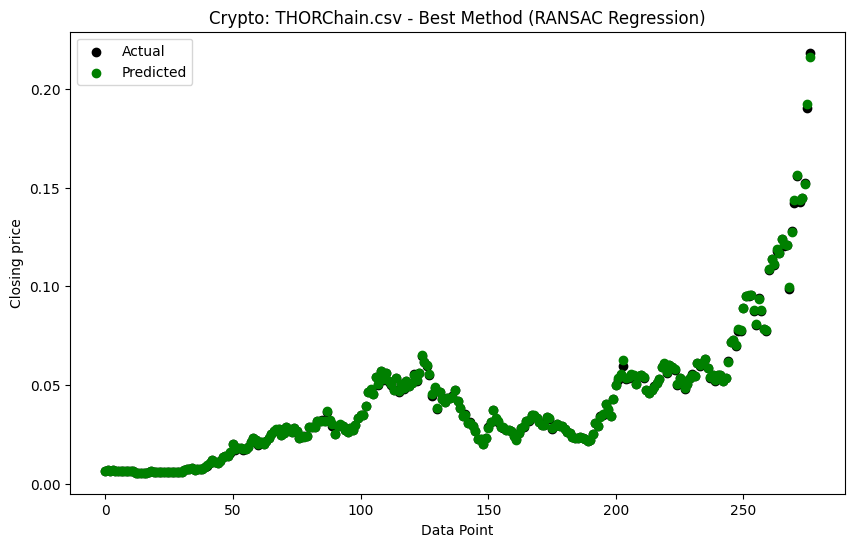

<Figure size 1000x600 with 0 Axes>

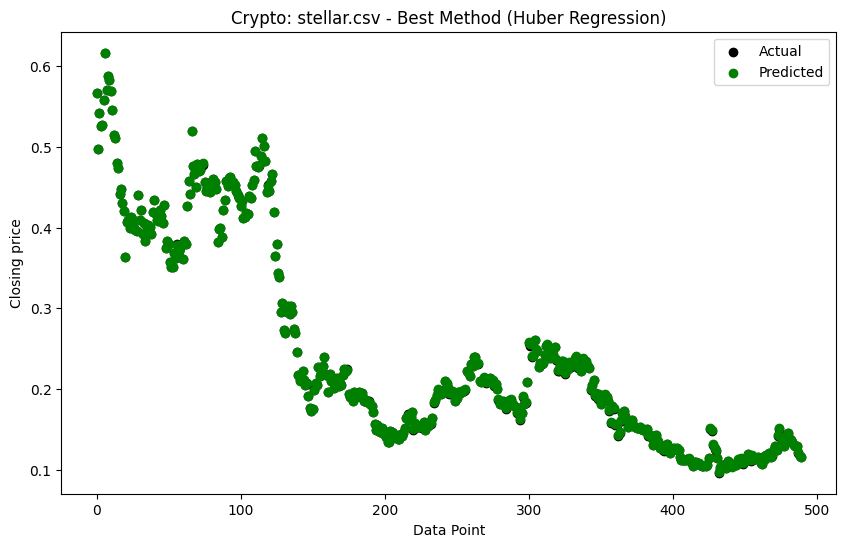

<Figure size 1000x600 with 0 Axes>

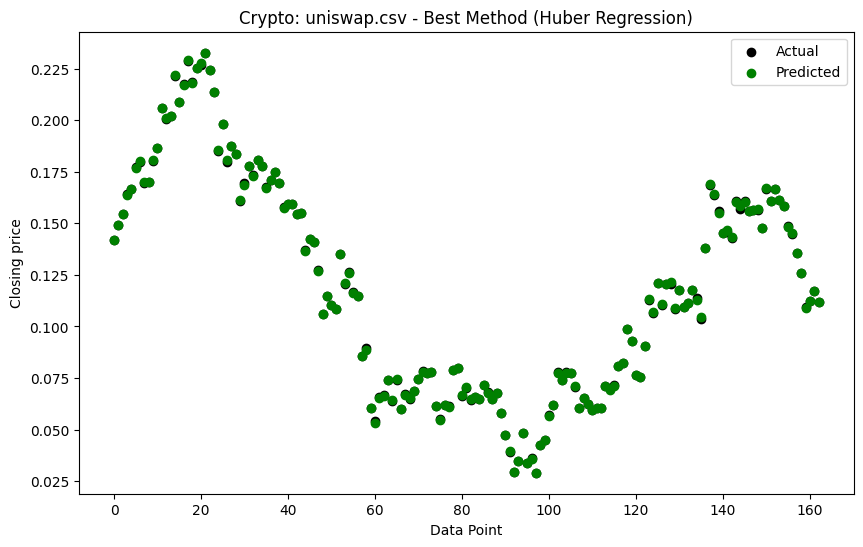

<Figure size 1000x600 with 0 Axes>

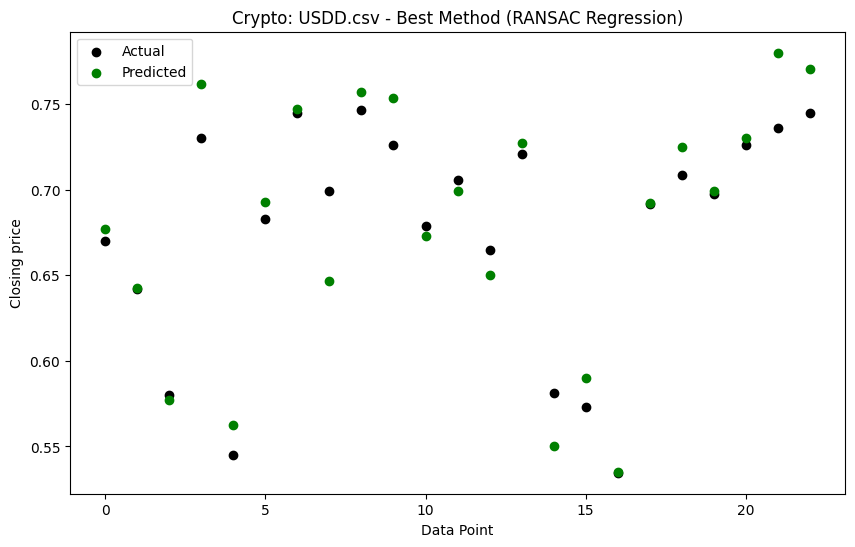

<Figure size 1000x600 with 0 Axes>

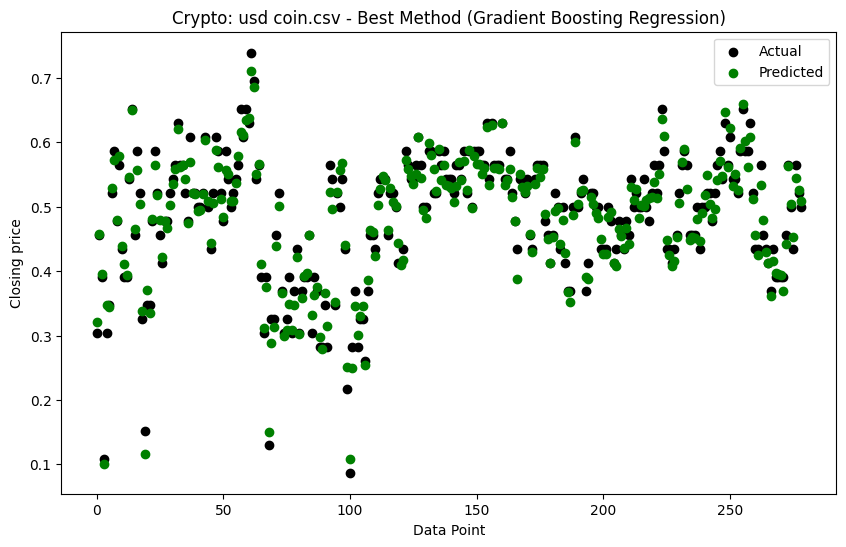

<Figure size 1000x600 with 0 Axes>

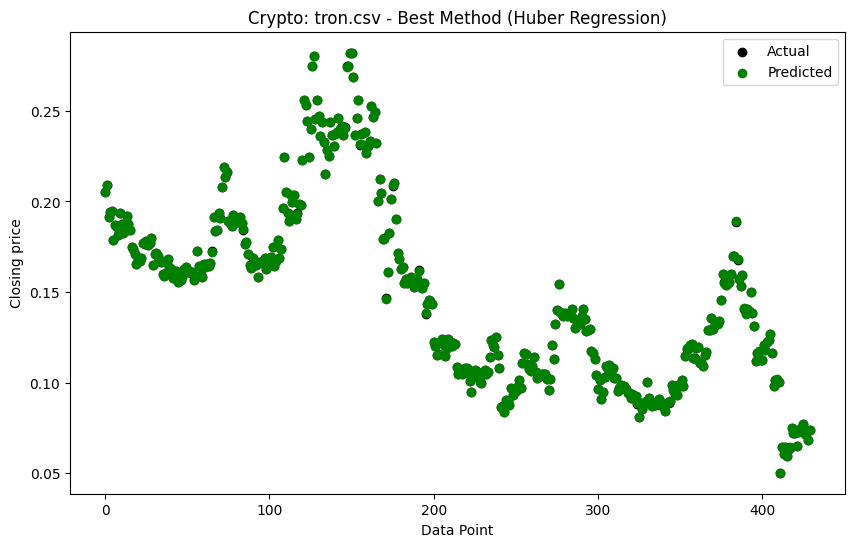

<Figure size 1000x600 with 0 Axes>

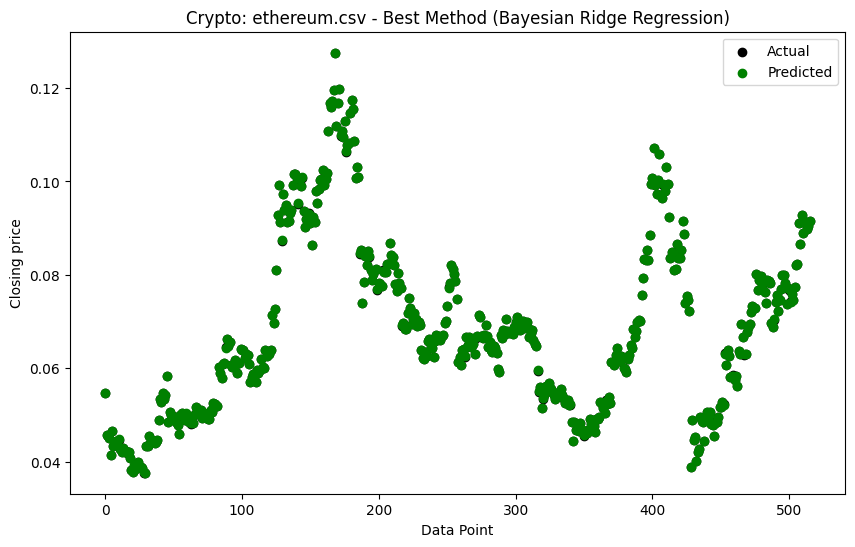

<Figure size 1000x600 with 0 Axes>

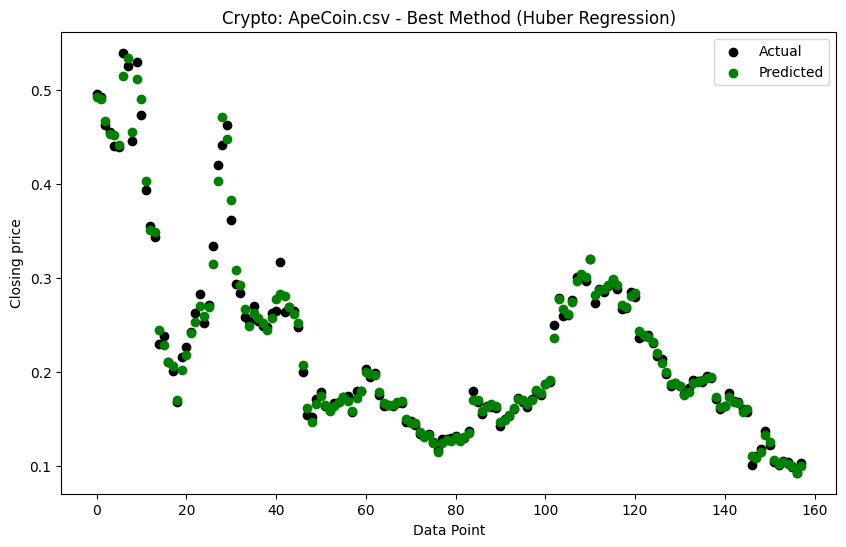

<Figure size 1000x600 with 0 Axes>

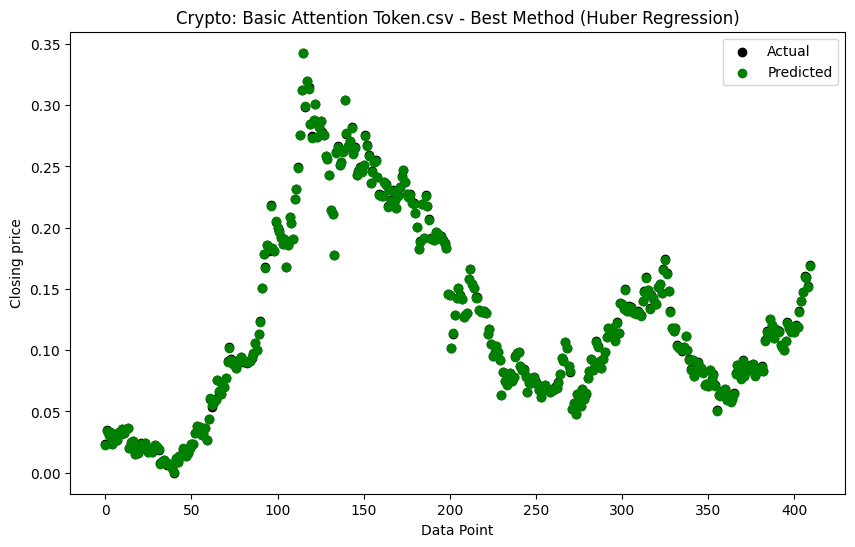

<Figure size 1000x600 with 0 Axes>

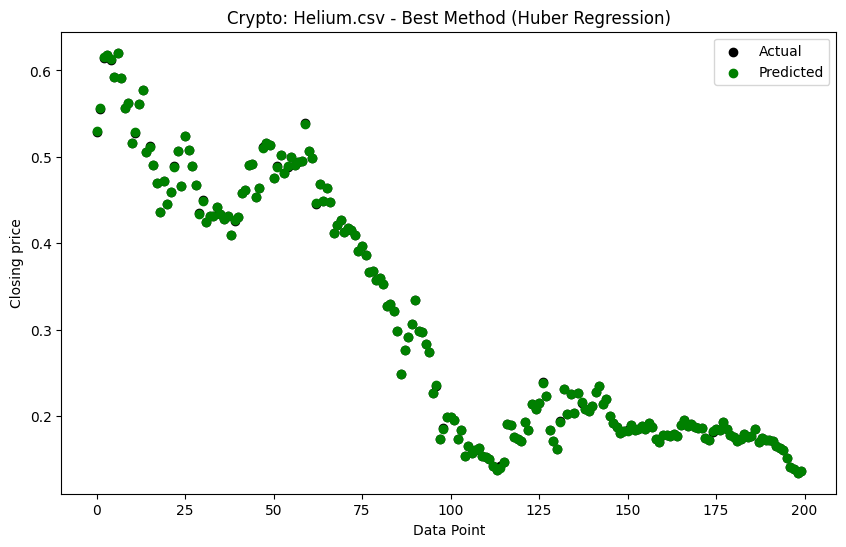

<Figure size 1000x600 with 0 Axes>

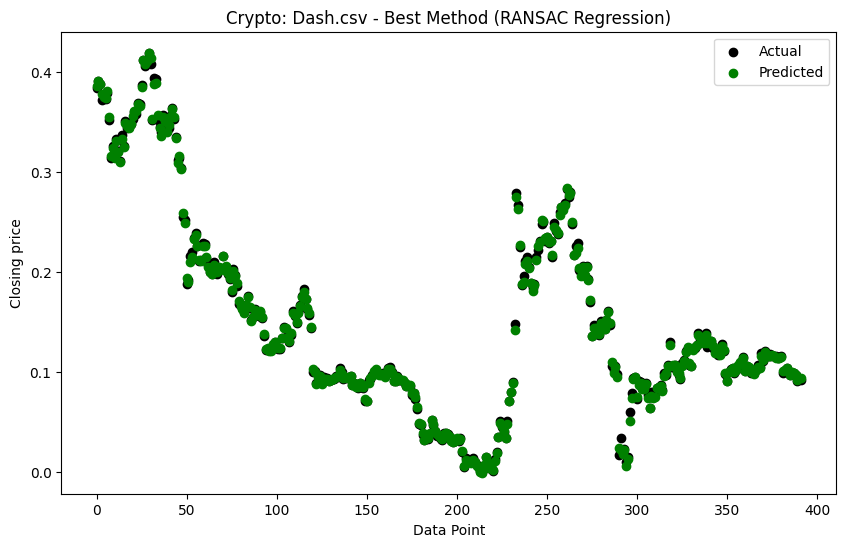

<Figure size 1000x600 with 0 Axes>

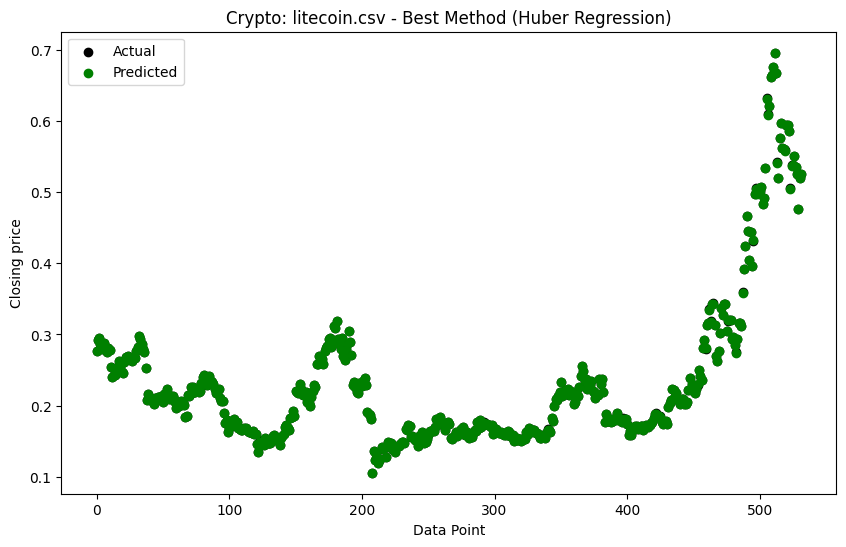

<Figure size 1000x600 with 0 Axes>

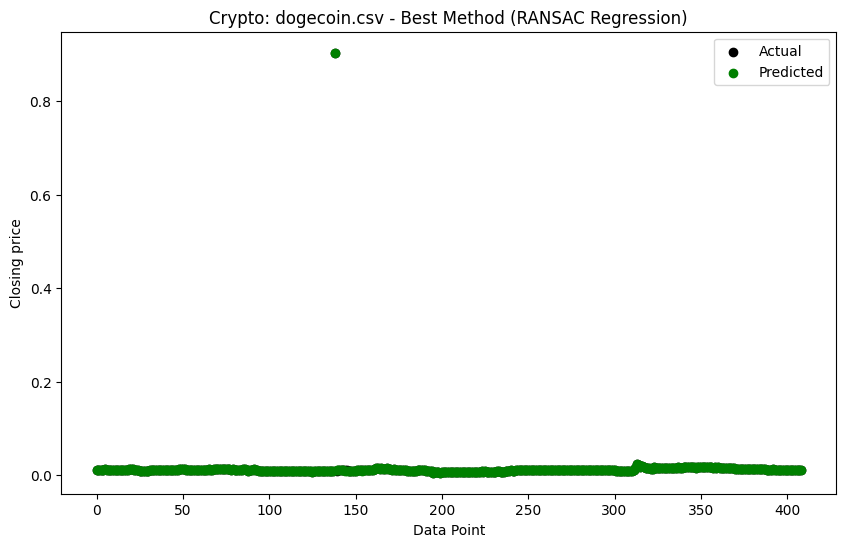

<Figure size 1000x600 with 0 Axes>

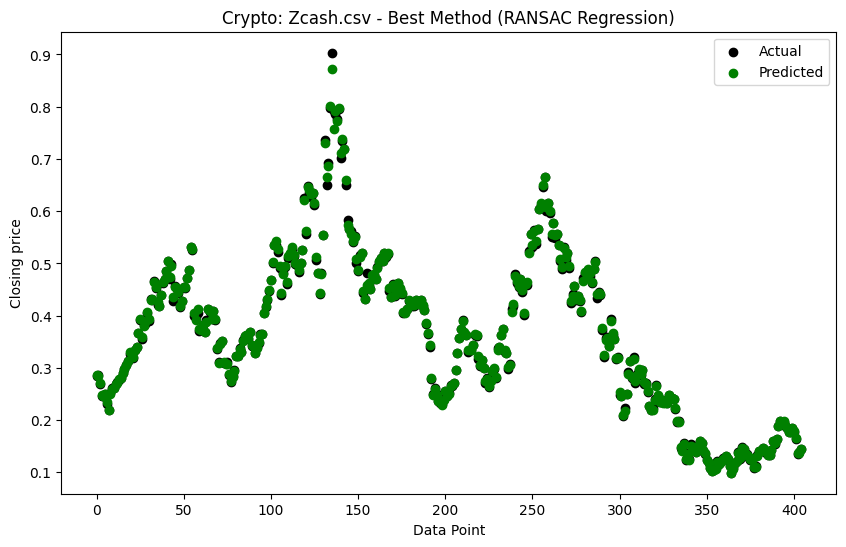

<Figure size 1000x600 with 0 Axes>

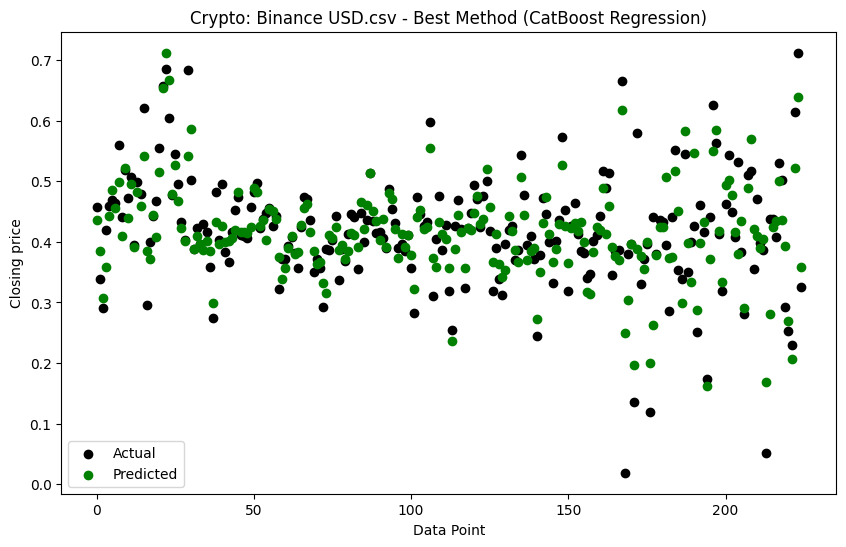

<Figure size 1000x600 with 0 Axes>

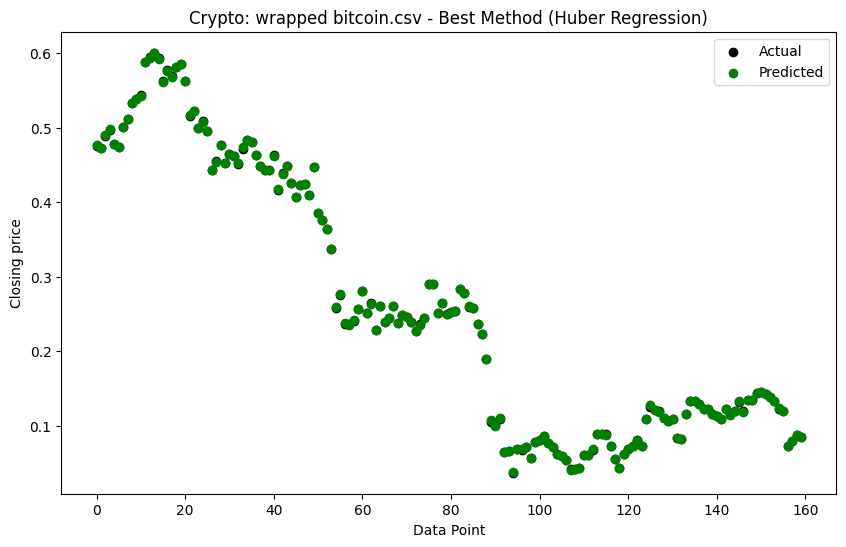

<Figure size 1000x600 with 0 Axes>

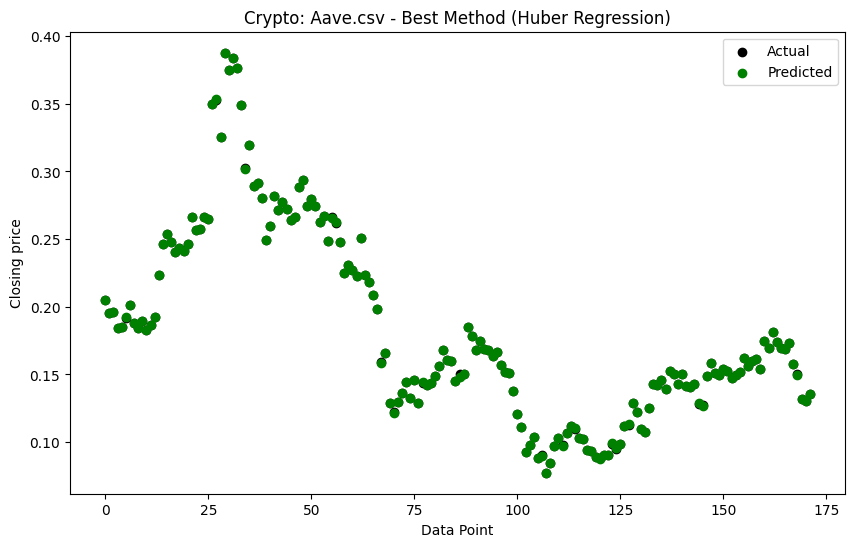

<Figure size 1000x600 with 0 Axes>

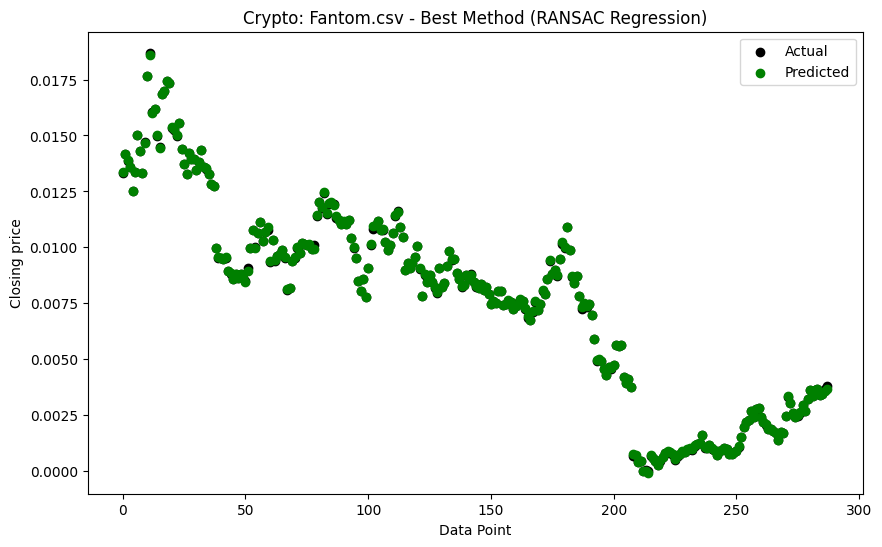

<Figure size 1000x600 with 0 Axes>

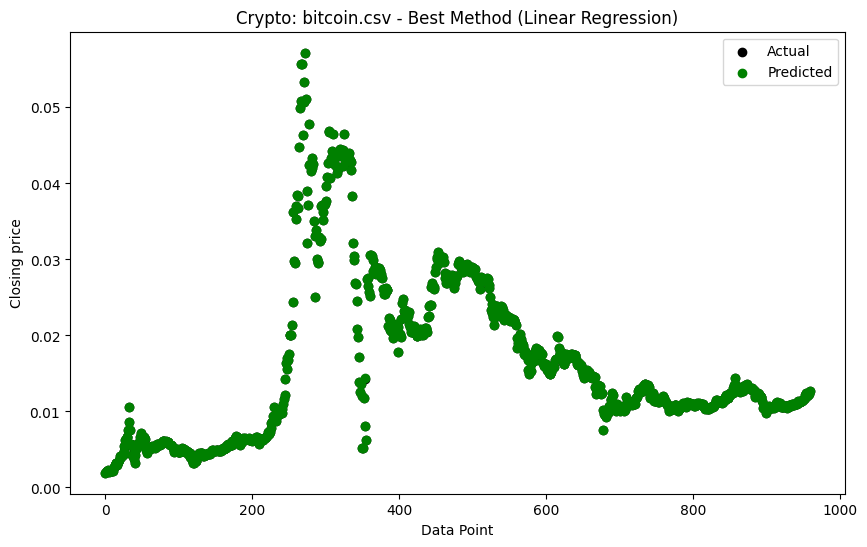

In [ ]:
# List to store filenames and their corresponding MAPEs
mape_list = []

# DataFrame to store performance metrics for all methods
results_df = pd.DataFrame(columns=['File', 'Method', 'RMSE', 'MAE', 'MAPE'])

# Check if GPU is available and set device placement
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available, falling back to CPU.")

# Répertoire contenant les fichiers CSV des crypto-monnaies
directory = "crypto_data"

# Iterate over all files in the directory
for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):
        try:
            data = pd.read_csv(os.path.join(directory, file_name))
            # Ensure the file contains the necessary columns
            if all(col in data.columns for col in ['Close', 'Volume', 'Open', 'High', 'Low']):
                # Remove outliers using IQR method
                Q1 = data['Close'].quantile(0.25)
                Q3 = data['Close'].quantile(0.75)
                IQR = Q3 - Q1
                data = data[(data['Close'] > (Q1 - 1.5 * IQR)) & (data['Close'] < (Q3 + 1.5 * IQR))].reset_index()

                # Normalize the data
                scaler = MinMaxScaler()
                data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

                # Feature selection: Open, High, Low, Close, Volume
                X = data[['Open', 'High', 'Low', 'Volume']].shift(1)  # Shift features backward by one day
                # Target selection: Next day's closing price
                y = data['Close'].shift(-1)  # Shift target variable forward by one day

                # Drop the last row (NaN in y) and the first row (NaN in X due to shifting)
                X = X.iloc[1:]
                y = y.dropna()

                # Adding moving averages
                sma_10 = data['Close'].rolling(window=2).mean().fillna(0)
                sma_20 = data['Close'].rolling(window=3).mean().fillna(0)

                # Adding RSI (Relative Strength Index)
                delta = data['Close'].diff()
                gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
                rs = gain / loss
                rsi = 100 - (100 / (1 + rs))
                rsi = rsi.fillna(0)

                # Adding MACD (Moving Average Convergence Divergence)
                ema_12 = data['Close'].ewm(span=12, min_periods=0, adjust=False).mean()
                ema_26 = data['Close'].ewm(span=26, min_periods=0, adjust=False).mean()
                macd = ema_12 - ema_26
                macd_signal = macd.ewm(span=9, min_periods=0, adjust=False).mean()

                # Calculate historical volatility (HV) or standard deviation of returns
                historical_volatility = data['Close'].pct_change().rolling(window=20).std().fillna(0)

                # Concatenate the additional features with X after shifting them backward by one day
                additional_features = pd.concat([sma_10, sma_20, rsi, macd, macd_signal, historical_volatility], axis=1).shift(1).dropna()
                X = np.column_stack((X, additional_features))

                # Target selection: current closing price
                y = data['Close']  # Remove the first element

                # Define the methods to try with their respective parameter grids for grid search
                methods = {
                    "Linear Regression": (LinearRegression(), {'fit_intercept': [True, False], 'positive': [True, False]}),
                    "Ridge Regression": (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
                    "Random Forest Regression": (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
                    "Gradient Boosting Regression": (GradientBoostingRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}),
                    "Support Vector Regression": (SVR(), {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 1.0, 10.0]}),
                    "K-Nearest Neighbors Regression": (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
                    "Bayesian Ridge Regression": (BayesianRidge(), {'alpha_1': [1e-06, 1e-05, 1e-04]}),
                    "Huber Regression": (HuberRegressor(max_iter=int(1e6)), {'alpha': [0.0001, 0.001, 0.01]}),
                    "Lars Regression": (Lars(), {'fit_intercept': [True, False]}),
                    "Passive Aggressive Regression": (PassiveAggressiveRegressor(), {'C': [0.1, 1.0, 10.0]}),
                    "RANSAC Regression": (RANSACRegressor(), {'min_samples': [None, 5, 10], 'max_trials': [100, 200, 300]}),
                    "Decision Tree Regression": (DecisionTreeRegressor(), {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}),
                    "Gaussian Process Regression": (GaussianProcessRegressor(), {}),
                    "Multi-layer Perceptron Regression": (MLPRegressor(solver='adam', max_iter=int(1e6)), {'hidden_layer_sizes': [(10,), (50,), (100,)]}),
                    "AdaBoost Regression": (AdaBoostRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}),
                    "XGBoost Regression": (XGBRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3]}),
                    "CatBoost Regression": (CatBoostRegressor(verbose=0), {'n_estimators': [50, 100, 200], 'depth': [4, 6, 8]}),
                }

                # Set up a single plot for each CSV file
                plt.figure(figsize=(10, 6))

                best_rmse = float('inf')
                best_method = None
                best_predictions = None

                # Iterate over the methods
                for method_name, (method, param_grid) in methods.items():
                    # Set up time series cross-validation
                    tscv = TimeSeriesSplit(n_splits=3)
                    for train_index, test_index in tscv.split(X):
                        X_train, X_test = X[train_index], X[test_index]
                        y_train, y_test = y[train_index], y[test_index]

                        # Set up grid search for the current method
                        grid_search = GridSearchCV(method, param_grid, scoring='neg_mean_squared_error', cv=3)
                        # Fit grid search
                        grid_search.fit(X_train, y_train)
                        # Get the best estimator
                        best_estimator = grid_search.best_estimator_
                        # Prediction on the test set
                        y_pred = best_estimator.predict(X_test)

                        # Compute performance metrics
                        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                        mae = mean_absolute_error(y_test, y_pred)
                        # Store results in the DataFrame
                        results_df = pd.concat([results_df, pd.DataFrame({'File': [file_name], 'Method': [method_name],
                                                        'RMSE': [rmse], 'MAE': [mae]})], ignore_index=True)
                        # Keep the best method
                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_method = method_name
                            close = y_test
                            best_predictions = y_pred

                # Plotting results for the best method
                plt.figure(figsize=(10, 6))
                plt.scatter(range(len(y_test)), close.values, color='black', label='Actual')
                plt.scatter(range(len(y_test)), best_predictions, color='green', label='Predicted')
                plt.title(f'Crypto: {file_name} - Best Method ({best_method})')
                plt.xlabel('Data Point')
                plt.ylabel('Closing price')
                plt.legend()
                plt.show()

            else:
                print(f"The file {file_name} does not contain necessary columns.")
        except Exception as e:
            print(f"An error occurred while processing the file {file_name}: {str(e)}")

# Sorting the results by RMSE
results_df = results_df.sort_values(by='RMSE')

In [ ]:
# Displaying the sorted results
results_df.groupby('Method').mean().sort_values(by='RMSE')

<ipython-input-12-a663fb825814>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby('Method').mean().sort_values(by='RMSE')


,RMSE,MAE
Method,,
Linear Regression,0.018553,0.009875
RANSAC Regression,0.019696,0.010922
Huber Regression,0.020613,0.013310
Bayesian Ridge Regression,0.021142,0.012325
Ridge Regression,0.034727,0.023866
Random Forest Regression,0.065031,0.045649
Gradient Boosting Regression,0.065439,0.045188
XGBoost Regression,0.070557,0.049508
AdaBoost Regression,0.074398,0.053031


<Figure size 2000x1000 with 0 Axes>

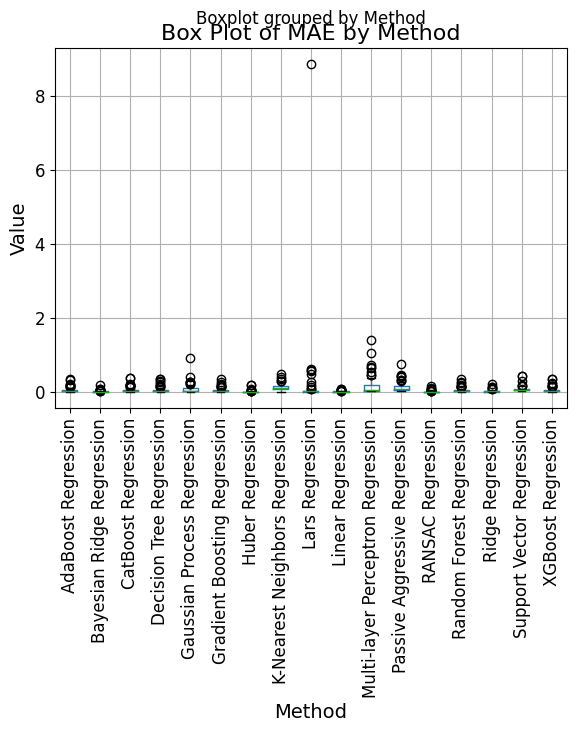

<Figure size 2000x1000 with 0 Axes>

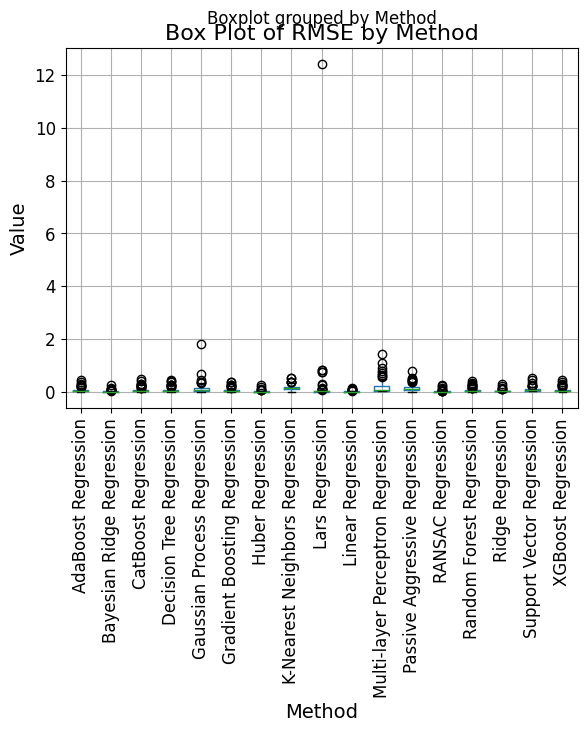

In [ ]:
plt.figure(figsize=(20, 10))  # Increase width to 20 inches and height to 10 inches
results_df.boxplot(column=['MAE'], by='Method', rot=90)
plt.title('Box Plot of MAE by Method', fontsize=16)  # Adjust title fontsize
plt.xlabel('Method', fontsize=14)  # Adjust xlabel fontsize
plt.ylabel('Value', fontsize=14)  # Adjust ylabel fontsize
plt.xticks(fontsize=12)  # Adjust xticks fontsize
plt.yticks(fontsize=12)  # Adjust yticks fontsize
plt.show()

plt.figure(figsize=(20, 10))  # Increase width to 20 inches and height to 10 inches
results_df.boxplot(column=['RMSE'], by='Method', rot=90)
plt.title('Box Plot of RMSE by Method', fontsize=16)  # Adjust title fontsize
plt.xlabel('Method', fontsize=14)  # Adjust xlabel fontsize
plt.ylabel('Value', fontsize=14)  # Adjust ylabel fontsize
plt.xticks(fontsize=12)  # Adjust xticks fontsize
plt.yticks(fontsize=12)  # Adjust yticks fontsize
plt.show()

<Figure size 2000x1000 with 0 Axes>

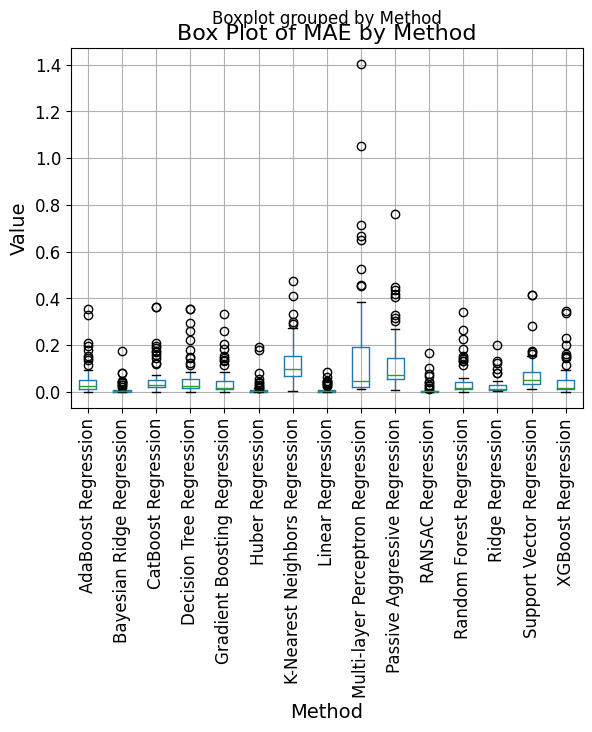

<Figure size 2000x1000 with 0 Axes>

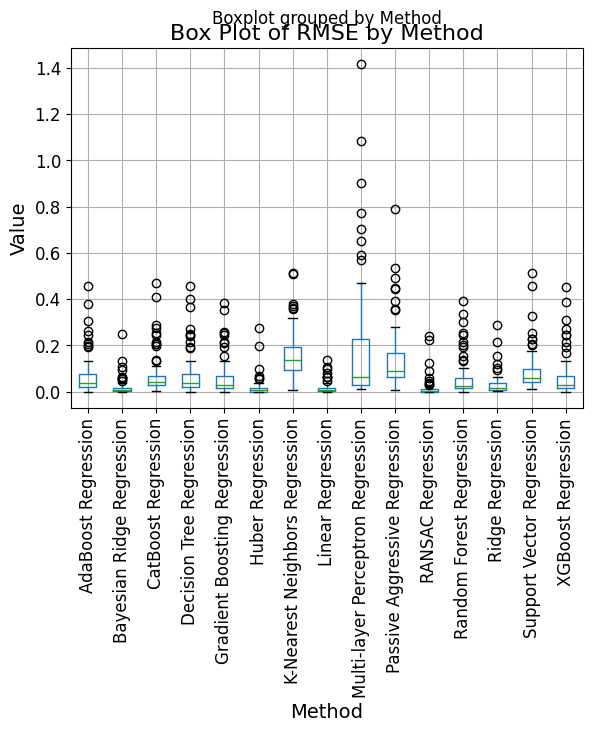

In [ ]:
plt.figure(figsize=(20, 10))  # Increase width to 20 inches and height to 10 inches
results_df[~results_df['Method'].isin(['Gaussian Process Regression', 'Lars Regression'])].boxplot(column=['MAE'], by='Method', rot=90)
plt.title('Box Plot of MAE by Method', fontsize=16)  # Adjust title fontsize
plt.xlabel('Method', fontsize=14)  # Adjust xlabel fontsize
plt.ylabel('Value', fontsize=14)  # Adjust ylabel fontsize
plt.xticks(fontsize=12)  # Adjust xticks fontsize
plt.yticks(fontsize=12)  # Adjust yticks fontsize
plt.show()

plt.figure(figsize=(20, 10))  # Increase width to 20 inches and height to 10 inches
results_df[~results_df['Method'].isin(['Gaussian Process Regression', 'Lars Regression'])].boxplot(column=['RMSE'], by='Method', rot=90)
plt.title('Box Plot of RMSE by Method', fontsize=16)  # Adjust title fontsize
plt.xlabel('Method', fontsize=14)  # Adjust xlabel fontsize
plt.ylabel('Value', fontsize=14)  # Adjust ylabel fontsize
plt.xticks(fontsize=12)  # Adjust xticks fontsize
plt.yticks(fontsize=12)  # Adjust yticks fontsize
plt.show()